Каспаров Иоанн 6132

Salt and pepper

In [43]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
import time
import cv2
import random
import cupy as cp
from PIL import Image

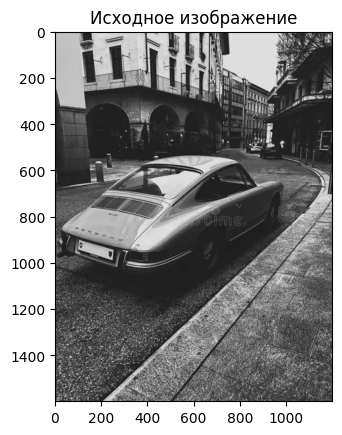

In [107]:
# Загрузка изображения
image = cv2.imread("image_4.bmp", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
image_1 = image.copy()

In [108]:
# Добавление шума
def noise_adding(noised_image, percent):
  rand = np.random.rand(noised_image.shape[0], noised_image.shape[1])
  noised_image[rand < percent] = 0
  noised_image[rand > 1 - percent] = 255
  return noised_image

Text(0.5, 1.0, 'Зашумленное изображение')

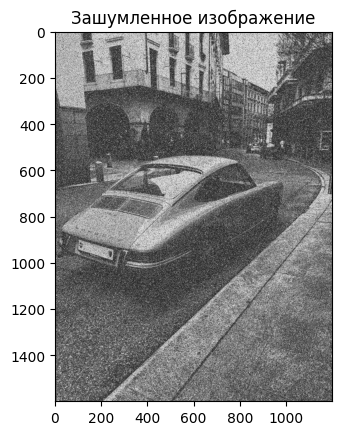

In [109]:
# Добавление шума к изображению
noise_image = noise_adding(image, 0.1)
plt.imshow(noise_image, cmap='gray')
plt.title('Зашумленное изображение')

In [97]:
def median_filter_cpu(noise_image):
    # Создаем пустое изображение с теми же размерами, что и входное изображение
    filtered_image = np.zeros_like(noise_image)

    # Проходимся по каждому пикселю входного изображения
    for i in range(1, noise_image.shape[0] - 1):
        for j in range(1, noise_image.shape[1] - 1):
            # Выбираем 9-точечный квадрат вокруг текущего пикселя
            window = noise_image[i-1:i+2, j-1:j+2]

            # Преобразуем окно в одномерный массив и находим медиану
            median_value = np.median(window.flatten())

            # Записываем медианное значение в соответствующий пиксель фильтрованного изображения
            filtered_image[i, j] = median_value

    # Заполнение недостающих значений для крайних строк и столбцов
    filtered_image[0, :] = filtered_image[1, :]
    filtered_image[-1, :] = filtered_image[-2, :]
    filtered_image[:, 0] = filtered_image[:, 1]
    filtered_image[:, -1] = filtered_image[:, -2]

    return filtered_image

Время выполнения на CPU:  38.165467977523804


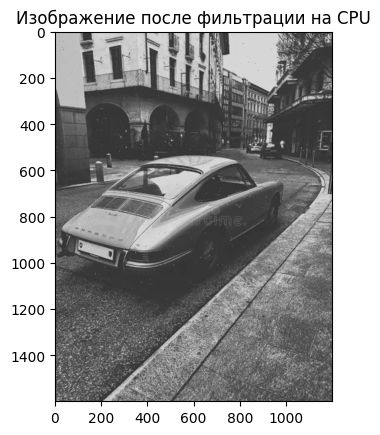

In [110]:
# Замер времени
start_time_cpu = time.time()

filtering_image_cpu = median_filter_cpu(noise_image)
plt.imshow(filtering_image_cpu, cmap='gray')

end_time_cpu = time.time()
elapsed_time_cpu = end_time_cpu - start_time_cpu

plt.title('Изображение после фильтрации на CPU')
print("Время выполнения на CPU: ", elapsed_time_cpu)


In [111]:
# Создаем массив для входных и выходных данных на устройстве
input_data = cuda.to_device(noise_image)
output_data = cuda.device_array_like(np.array(noise_image))

# Конфигурация блоков и потоков для выполнения на GPU
threadsperblock = (16, 16)
blockspergrid_x = (np.array(noise_image).shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (np.array(noise_image).shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

In [100]:
@cuda.jit
def median_filter_gpu(input_image, output_image):
    i, j = cuda.grid(2)

    if 0 < i < input_image.shape[0] - 1 and 0 < j < input_image.shape[1] - 1:
        neighbors = cuda.local.array(9, dtype=np.int32)
        idx = 0
        for x in range(-1, 2): #краевые условия - ni, nj не выходят за границы изображения
            for y in range(-1, 2):
                ni, nj = i + x, j + y
                ni = max(0, min(input_image.shape[0] - 1, ni))
                nj = max(0, min(input_image.shape[0] - 1, nj))
                neighbors[idx] = input_image[ni, nj]
                idx += 1

        for k in range(9): #поиск медианы
            for l in range(k + 1, 9):
                if neighbors[l] < neighbors[k]:
                    neighbors[k], neighbors[l] = neighbors[l], neighbors[k]

        # Сохраняем медианный элемент в выходной массив
        output_image[i, j] = neighbors[4]

Время выполнения на GPU: 0.0018973350524902344 секунд


Text(0.5, 1.0, 'Изображение после фильтрации на GPU')

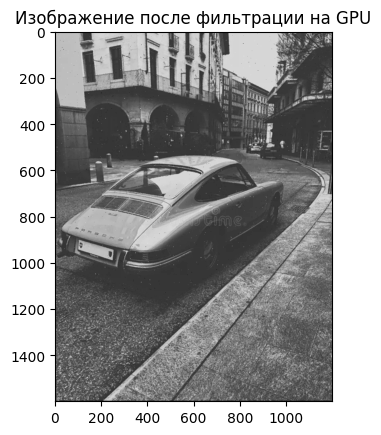

In [121]:
# Замер времени на GPU
start_time_gpu = time.time()

median_filter_gpu[blockspergrid, threadsperblock](input_data, output_data)

cp.cuda.Device().synchronize()
end_time_gpu = time.time()
elapsed_time_gpu = end_time_gpu - start_time_gpu

print(f"Время выполнения на GPU: {elapsed_time_gpu} секунд")

result_gpu = output_data.copy_to_host()

plt.imshow(result_gpu, cmap='gray')
plt.title('Изображение после фильтрации на GPU')

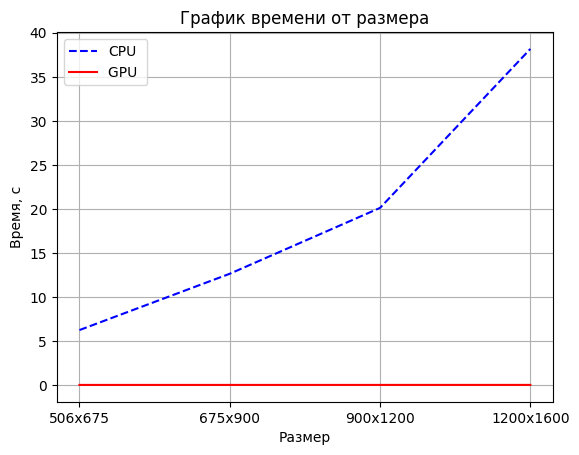

In [127]:
import matplotlib.pyplot as plt
time_cpu = [6.2307751178741455, 12.627189874649048, 20.10964560508728, 38.165467977523804]
time_gpu = [0.0007190704345703125, 0.0008330345153808594, 0.001508474349975586, 0.0016973350524902344 ]
size = ['506x675', '675x900', '900x1200', '1200x1600']
plt.title('График времени от размера')
plt.xlabel('Размер')
plt.ylabel('Время, с')
plt.plot(size,time_cpu,'b--',size,time_gpu,'red')
plt.legend(['CPU','GPU '], loc=2)
plt.grid(True)
plt.show()

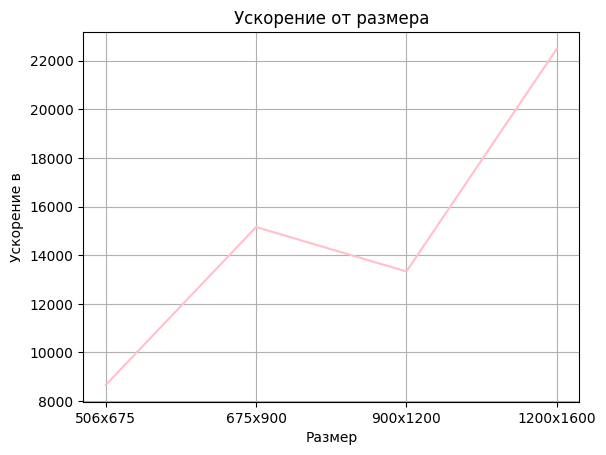

In [129]:
plt.cla()
plt.title('Ускорение от размера')
plt.xlabel('Размер')
plt.ylabel('Ускорение в')
accel = []
for i in range (len(time_cpu)):
  accel.append(time_cpu[i]/time_gpu[i])

plt.plot(size,accel,'pink')
plt.grid(True)
plt.show()

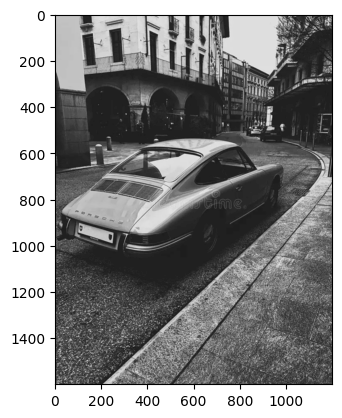

In [106]:
# 506x675 675x900 900x1200 1200x1600

img = Image.fromarray(image_1, mode="L")
image_4 = img.resize((1200, 1600))

image_4.save('image_4.bmp')
plt.imshow(image_4, cmap='gray')

